In [1]:
import numpy as np
import pandas as pd
import nltk
import csv

In [30]:
import numpy as np
import pandas as pd
import nltk
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import requests
import json
import re

In [3]:
from scipy.misc import imread
from wordcloud import WordCloud,ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

In [4]:
df = pd.read_csv('lipstick.csv')

In [5]:
df[50:58]

,Unnamed: 0,product_name,brand_name,price,love_count,color,rgb,link
50,50,Matte Revolution Lipstick,CHARLOTTE TILBURY,34.0,55206,Glastonberry muted purple berry,"(145, 76, 121)",https://www.sephora.com/product/matte-revoluti...
51,51,Matte Revolution Lipstick,CHARLOTTE TILBURY,34.0,55206,Love Liberty berry pink,"(163, 33, 97)",https://www.sephora.com/product/matte-revoluti...
52,52,Gloss Bomb Universal Lip Luminizer,FENTY BEAUTY BY RIHANNA,18.0,256222,Diamond Milk shimmering pearl,"(223, 204, 197)",https://www.sephora.com/product/gloss-bomb-uni...
53,53,Gloss Bomb Universal Lip Luminizer,FENTY BEAUTY BY RIHANNA,18.0,256222,Fenty Glow shimmering rose nude,"(181, 105, 91)",https://www.sephora.com/product/gloss-bomb-uni...
54,54,Velvet Matte Lipstick Pencil,NARS,27.0,309898,Get Off pink beige,"(243, 160, 146)",https://www.sephora.com/product/velvet-matte-l...
55,55,Velvet Matte Lipstick Pencil,NARS,27.0,309898,Intriguing rose pink,"(241, 139, 150)",https://www.sephora.com/product/velvet-matte-l...
56,56,Velvet Matte Lipstick Pencil,NARS,27.0,309898,Roman Holiday vibrant pink sheen,"(252, 159, 180)",https://www.sephora.com/product/velvet-matte-l...
57,57,Velvet Matte Lipstick Pencil,NARS,27.0,309898,Out of stock: Do Me Baby chestnut rose,"(217, 129, 151)",https://www.sephora.com/product/velvet-matte-l...


In [6]:
# df = df[ ~ df['product_name'].str.contains('Set') ]
invalid_info = df[df['price'].isna()]['price'].values
df = df[-df['price'].isin(invalid_info)]
invalid_info = df[df['love_count'].isna()]['love_count'].values
df = df[-df['love_count'].isin(invalid_info)]
df = df[ ~ df['product_name'].str.contains('Set') ]
df = df.reset_index(drop=True)

In [7]:
df.head()

,Unnamed: 0,product_name,brand_name,price,love_count,color,rgb,link
0,0,Lip Maestro,GIORGIO ARMANI BEAUTY,38.0,103038,Out of stock: 405,"(141, 6, 2)",https://www.sephora.com/product/lip-maestro-P3...
1,1,Lip Maestro,GIORGIO ARMANI BEAUTY,38.0,103038,507,"(144, 75, 94)",https://www.sephora.com/product/lip-maestro-P3...
2,2,Lip Maestro,GIORGIO ARMANI BEAUTY,38.0,103038,406,"(137, 38, 33)",https://www.sephora.com/product/lip-maestro-P3...
3,3,Lip Maestro,GIORGIO ARMANI BEAUTY,38.0,103038,508,"(245, 161, 151)",https://www.sephora.com/product/lip-maestro-P3...
4,4,Lip Maestro,GIORGIO ARMANI BEAUTY,38.0,103038,Out of stock: 400,"(163, 25, 23)",https://www.sephora.com/product/lip-maestro-P3...


In [8]:
df = df.sort_values(by='love_count', ascending=False)
df = df.reset_index(drop=True)

In [9]:
# df['slicing'] = [len(i) for i in df['brand_name']]

In [10]:
for i in range(len(df['color'])):
    if 'Out of stock: ' in str(df['color'].iloc[i]):
        df['color'].iloc[i] = df['color'].iloc[i][len('Out of stock: '): ]



In [11]:
df.head()

,Unnamed: 0,product_name,brand_name,price,love_count,color,rgb,link
0,107,Everlasting Liquid Lipstick,KAT VON D,20.0,1148262,Muñeca nude petal,"(228, 108, 110)",https://www.sephora.com/product/everlasting-lo...
1,125,Everlasting Liquid Lipstick,KAT VON D,20.0,1148262,Santa Sangre poison apple,"(208, 58, 59)",https://www.sephora.com/product/everlasting-lo...
2,115,Everlasting Liquid Lipstick,KAT VON D,20.0,1148262,Hawkwind nude sienna,"(157, 64, 74)",https://www.sephora.com/product/everlasting-lo...
3,116,Everlasting Liquid Lipstick,KAT VON D,20.0,1148262,Sanctuary nude coffee,"(142, 79, 87)",https://www.sephora.com/product/everlasting-lo...
4,117,Everlasting Liquid Lipstick,KAT VON D,20.0,1148262,Crucifix deep chocolate,"(114, 66, 64)",https://www.sephora.com/product/everlasting-lo...


# The top 5 loved lipsticks

In [12]:
def popular_lipstick(df):
    popular_lipstick = list()
    df_popular = df.groupby(['product_name','brand_name','love_count']).count().sort_values(by='love_count', ascending=False)
    df_popular.reset_index(inplace=True)
    for i in range(5):
        popular_lipstick.append((df_popular['product_name'].iloc[i], df_popular['brand_name'].iloc[i], df_popular['price'].iloc[i]))
    return popular_lipstick
popular_lipstick = popular_lipstick(df)
print( 'The top 5 loved lipsticks are:') 
popular_lipstick

The top 5 loved lipsticks are:


[('Everlasting Liquid Lipstick', 'KAT VON D', 32),
 ('Liquid Lipstick', 'ANASTASIA BEVERLY HILLS', 32),
 ('Cream Lip Stain Liquid Lipstick', 'SEPHORA COLLECTION', 12),
 ('Vice Lipstick', 'URBAN DECAY', 3),
 ('Full-On™ Plumping Lip Polish Gloss', 'BUXOM', 10)]

# Function for info

In [13]:
def get_lipstick_reviews(link):
    reviews = list()
    pattern = re.compile(r'P\d+')
    product_id = re.search(pattern, string = link).group()
    off_set = 0
    while True:
        api_url = ''.join(["https://api.bazaarvoice.com/data/reviews.json?Filter=ProductId%3A",
                          product_id,
                          "&Sort=Helpfulness%3Adesc&Limit=100&Offset=",
                           str(off_set),
                           "&Include=Products%2CComments&Stats=Reviews&passkey=rwbw526r2e7spptqd2qzbkp7&apiversion=5.4"])
        response = requests.get(api_url)
        results = json.loads(response.content, encoding = 'utf-8')['Results']
        if results:
            for review in results:
                reviews.append(review['ReviewText'])
        else:
            break
        off_set += 100
    return reviews

# Function for link

In [14]:
def search_link(brand_name, product_name):
    search_df = df[(df['product_name'] == product_name) & (df['brand_name'] == brand_name)]
    link = search_df['link'].iloc[0]
    return link

In [15]:
# https://www.sephora.com/product/lip-maestro-P393411?skuId=1441591&keyword=giorio%20armani%20lip%20maestro%20401
product_name = 'Matte Revolution Lipstick'
brand_name = 'CHARLOTTE TILBURY'
link = search_link(brand_name, product_name)
link

'https://www.sephora.com/product/matte-revolution-lipstick-P433530?icid2=products grid:p433530:product'

In [16]:
outcome = get_lipstick_reviews(link)
outcome

['This is my all time favorite lipstick! The color is perfect for my skin tone and matches with any outfit I wear. It also is very pigmented and stays on my lips most of the day. I also get so many compliments when I wear this. It also glides on so softly and feels so pillowy on the lips.',
 'I am beyond thrilled that Sephora now carries Charlotte Tilbury! Her makeup has been my beauty secret for years! I have this lipstick in Pillow Talk, Very Victoria, Bond Girl. Pillow Talk exactly mimics my lip color. Very Victoria is more of a nude lip. Bond Girl is the perfect berry/rosy red. Charlotte’s matte lipsticks are the only matte I will use! They do not dry out your lips and have massive staying power! I can’t recommend them enough!',
 'I bought Pillow Talk and Very Victoria from CharlotteTilbury online and I am stoked that Sephora is caring the CT Line.\nBoth colors look amazing on my Medium Olive Complexion; it wears very well, feels creamy and looks matte! \nWhat else could you ask fo

# Function for wordcloud

In [47]:
def get_wordcloud(outcome, product_name):
    texts = []
    [texts.append(review) for review in outcome]
    # outcome['reviews']
    text_string = ''
    text_string_2 = ''

    #Remove unwanted words
    DELETE_WORDS = ['lipstick', 'lip', 'idea', 'product', 'the','think', 'found','feel', 'lunch','even', 'really','color','look']
    def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
        for word in DELETE_WORDS:
            text_string = text_string.replace(word,' ')
        return text_string

    #Remove short words
    MIN_LENGTH = 1
    def remove_short_words(text_string,min_length = MIN_LENGTH):
        word_list = text_string.split()
        for word in word_list:
            if len(word) < min_length:
                text_string = text_string.replace(' '+word+' ',' ',1)
        return text_string



    #     for i in texts:
    #         string = remove_words(i)
    #         string = remove_short_words(string)
    #         text_string = text_string + string
    text_string_2 = [text_string + remove_short_words(remove_words(i)) for i in texts]
    #     words = word_tokenize(str(text_string_2))
    #     text_string_2 = [word.lower() for word in words
    #                       if word not in stopwords.words() and word.isalpha()]

    text_string_ = ''
    #     for i in text_string:
    #         text_attr = [i]
    #         tag = nltk.pos_tag(text_attr)
    #         if 'RB' in tag[0][1] or 'NN' in tag[0][1] or 'JJ' in tag[0][1]:
    #             text_string_ = text_string_ + ' ' + i
    text_string_ = [text_string_ + ' ' + i for i in text_string_2 if ('RB' in nltk.pos_tag([i])[0][1]) or ('NN' in nltk.pos_tag([i])[0][1]) or ('JJ' in nltk.pos_tag([i])[0][1])]
    text_string_
    bg_pic = imread('lip.jpg')
    wordcloud = WordCloud(stopwords=STOPWORDS, mask=bg_pic, background_color='white',width=1200,height=1500,max_words = 50).generate(str(text_string_))
    name = product_name +' ' + 'word_cloud.jpg'
    image_colors = ImageColorGenerator(bg_pic)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    WordCloud.to_file(wordcloud,name)
    return wordcloud

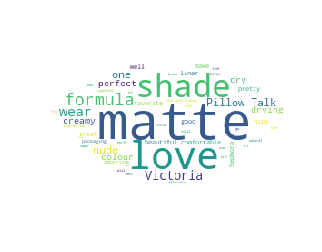

In [48]:
product_name = 'Matte Revolution Lipstick'
get_wordcloud(outcome,product_name)

# Brand Analysis

In [119]:
def get_brand_reviews(brand_name):
    df_brands = df.groupby(['product_name','brand_name','link']).count().sort_values(by='love_count', ascending=False)
    df_brands.reset_index(inplace=True)
    df_brand_review = df_brands[df_brands['brand_name'] == brand_name]
    reviews = []
    for i in df_brand_review['link']:
        review = get_lipstick_reviews(i)
        reviews.extend(review)
    return reviews

In [73]:
df_brands = df.groupby(['product_name','brand_name','link']).count().sort_values(by='love_count', ascending=False)
df_brands.reset_index(inplace=True)

In [89]:
outcomes = get_brand_reviews('GIVENCHY')

In [90]:
outcomes

["I used my points to get the sample of the #103, which looks like a dusty rose on the site. I would not describe this as dusty rose, but more of a slightly dark nude/coral. It can be different on everyone, but as someone who doesn't wear strong/bright lip colors often, this one is pretty daring for me while still being work appropriate.\n\nI love the formulation and the packaging...it truly feels like a luxury product. Even the sample has a nice weight, and the formulation is amazing: it feels creamy but has a nice matte look to it. There is some fading towards the inside of my lips, but it stays pretty strong on the outside so a single swipe reapply is all that is needed every few hours.\n\n$36 is super expensive for a lipstick, but I will definitely consider buying it when the sample runs out. I wear it about once a week, so I feel like it will last me a really long time.",
 "Got this as a sampler. I love how it stays on. It's lovely and hydrating. However I am not a fan of creamy l

# Brand Sentiment Analysis

In [93]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index) 
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()

In [94]:
def do_pos_neg_sentiment_analysis(outcomes,debug=False):
    text = ''
    for i in outcomes:
        text = text +' ' + i
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    cpos = cneg = lpos = lneg = 0
    for word in word_tokenize(text):
        if word in positive_words:
            if debug:
                print("Positive",word)
            cpos+=1
        if word in negative_words:
            if debug:
                print("Negative",word)
            cneg+=1
    results.append((('Positive Prob: ', cpos/len(word_tokenize(text))),('Negative Prob: ', cneg/len(word_tokenize(text)))))
    return results

In [95]:
do_pos_neg_sentiment_analysis(outcomes)

[(('Positive Prob: ', 0.06194912545097502),
  ('Negative Prob: ', 0.01763369411334886))]

# Brand Reviews Wordcloud

In [ ]:
brand_wordcloud = get_wordcloud(outcomes, brand_name)

# Customer Brand Emotions

In [99]:
def get_nrc_data():
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [100]:
emotion_dict = get_nrc_data()
emotion_dict['abandoned']

['anger', 'fear', 'negative', 'sadness']

In [106]:
def emotion_analyzer(texts,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0
    input_ = ''
    for text in texts:
        input_ = input_ + ' ' +text
        #Analyze the text and normalize by total number of words
    total_words = len(input_.split())
    for word in input_.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/len(text.split())
    return emotion_count

In [107]:
emotion_analyzer(outcomes)

{'anticipation': 120.5833333333383,
 'positive': 276.2083333333192,
 'negative': 86.70833333333445,
 'disgust': 28.16666666666692,
 'fear': 28.54166666666693,
 'sadness': 43.41666666666638,
 'surprise': 40.95833333333319,
 'joy': 157.83333333333235,
 'trust': 131.25000000000506,
 'anger': 24.208333333333474}

# Lipstick Reviews Summary

In [113]:
# Text- Summerization
def build_summary(texts):
    from nltk.tokenize import word_tokenize
    from nltk.tokenize import sent_tokenize
    from nltk.probability import FreqDist
    from nltk.corpus import stopwords
    from collections import OrderedDict
    summary_sentences = []
    candidate_sentences = {}
    candidate_sentence_counts = {}
    input_ = ''
    for text in texts:
        input_ = input_ + ' ' +text
    words = word_tokenize(text)
    
    lowercase_words = [word.lower() for word in words
                      if word not in stopwords.words() and word.isalpha()]
    
    word_frequencies = FreqDist(lowercase_words)
    most_frequent_words = FreqDist(lowercase_words).most_common(20)
    sentences = sent_tokenize(text)
    for sentence in sentences:
        candidate_sentences[sentence] = sentence.lower()
    for long, short in candidate_sentences.items():
        count = 0
        for freq_word, frequency_score in most_frequent_words:
            if freq_word in short:
                count += frequency_score
                candidate_sentence_counts[long] = count   
    sorted_sentences = OrderedDict(sorted(
                        candidate_sentence_counts.items(),
                        key = lambda x: x[1],
                        reverse = True)[:2])
    return sorted_sentences   

In [115]:
summary = '\n'.join(build_summary(outcome))
print(summary)

This lipstick is great: applies very easily and it feel very comfortable on the lips.
I think I found my newest shade of red.


In [116]:
df_brands = df.groupby(['product_name','brand_name','love_count']).count().sort_values(by='love_count', ascending=False)
df_brands.reset_index(inplace=True)

In [122]:
def brand_review_list():
    df_brands = df.groupby(['product_name','brand_name','love_count']).count().sort_values(by='love_count', ascending=False)
    df_brands.reset_index(inplace=True)
    brand_review_list = []
    for i in df_brands['brand_name']:
        outcomes = get_brand_reviews(i)
        analysis = do_pos_neg_sentiment_analysis(outcomes)
        brand_review_list.append((i,analysis))
    return brand_review_list